# Barcode Decoder Project - Model Training Notebook

* This notebook trains a YOLOv8 model to detect barcodes in images using a custom dataset. It prepares the data, trains the model, evaluates its accuracy, and saves the trained model for future use.

### Step 1 - Installer ultralytics (YOLOv8)

* This step mounts the Google Drive to Google Colab so that we can access the dataset and save models easily.

In [58]:
#!pip install ultralytics

### Step 2 - Vérifier que YOLO est bien importé

* Navigating to the main project folder inside Drive.

In [61]:
from ultralytics import YOLO

# Vérifier la version
!yolo version

8.3.223


### Step 3 -Lancer l’entraînement (CPU uniquement)

 * Unzipping the custom barcode dataset which contains train, valid, and test folders.

In [ ]:
# Charger le modèle YOLOv8n (le plus petit et rapide pour CPU)
model = YOLO('yolov8n.pt')

# Lancer l'entraînement
results = model.train(
    data=r"/content/drive/MyDrive/A62/Dataset/yolo_dataset/data.yaml",
    epochs=20,          # tu peux mettre 100 plus tard, mais 20 pour tester
    imgsz=416,          # taille des images
    device='cpu',       # forcer l'entraînement sur CPU
    batch=4,            # réduit pour éviter d’épuiser la RAM
    name='barcode_qr_test'  # dossier de sortie runs/detect/barcode_qr_test/
)

Ultralytics 8.3.223  Python-3.11.7 torch-2.6.0+cpu CPU (Intel Core i5-6600 3.30GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\CBDB\420-A62- Projet de synthse\Barcode & QR Codes\yolo_dataset\data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=barcode_qr_test3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_ma

### Step 4 -Vérifier le modèle sauvegardé

* Verifying if images and labels are present and correctly matched in training, validation, and testing sets.

In [67]:
# runs/detect/barcode_qr_test/weights/

### Step 5 - Tester sur une image

#### data.yaml defines:
      * Train, validation, test paths
      * Number of classes (nc: 1 → barcode)
      * Class names

#### Going to the Dataset Directory

In [23]:
from ultralytics import YOLO
# Charger le modèle entraîné
trained_model = YOLO(r"runs/detect/barcode_qr_test/weights/best.pt")

# Tester sur une image de ton dataset
# Faire la prédiction sans show=True
#results = trained_model.predict(source=r"C:\CBDB\420-A62- Projet de synthèse\Barcode & QR Codes\yolo_dataset\val\images\05102009118.jpg", save=False, conf=0.25, show=False)
results = trained_model.predict(source=r"C:\CBDB\420-A62- Projet de synthèse\Barcode & QR Codes\yolo_dataset\val\images\05102009228.jpg", save=False, conf=0.65, show=False)
#results = trained_model.predict(source=r"C:\CBDB\420-A62- Projet de synthèse\Barcode & QR Codes\yolo_dataset\val\images\05102009160.jpg", save=False, conf=0.65, show=False)
#results = trained_model.predict(source=r"C:\CBDB\420-A62- Projet de synthèse\Barcode & QR Codes\yolo_dataset\val\images\rotationsimage039_jpg.rf.0c0a7dd88a8f7213336d1e6c13ffbcc2.jpg", save=False, conf=0.65, show=False)
#results = trained_model.predict(source=r"C:\CBDB\420-A62- Projet de synthèse\Barcode & QR Codes\yolo_dataset\val\images\monitorimage015_jpg.rf.242ab966a1d45402f37aa525f5c8780b.jpg", save=False, conf=0.65, show=False)


image 1/1 C:\CBDB\420-A62- Projet de synthse\Barcode & QR Codes\yolo_dataset\val\images\05102009228.jpg: 416x320 1 barcode, 86.9ms
Speed: 5.4ms preprocess, 86.9ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 320)


In [25]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
!pip install pyzxing
from pyzxing import BarCodeReader
from pathlib import Path
#from pyzbar.pyzbar import decode
#print("✅ pyzbar et zbar sont bien chargés !")
import numpy as np


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
import math

def ean13_checksum_ok(code: str) -> bool:
    """Vérifie la validité du checksum d'un code EAN-13."""
    if not code.isdigit() or len(code) != 13:
        return False
    digits = list(map(int, code))
    checksum = (10 - ((sum(digits[::2]) + 3 * sum(digits[1:-1:2])) % 10)) % 10
    return checksum == digits[-1]


def filter_barcode_results(decoded_results, min_confidence=0.5, enable_checksum=False, max_dist=10):
    """
    Filtre les résultats ZXing pour réduire les faux positifs.
    
    Args:
        decoded_results (list): Liste de dicts renvoyés par ZXing.
        min_confidence (float): Niveau de confiance minimal pour garder un résultat.
        enable_checksum (bool): Vérifie la validité des checksums EAN/UPC.
        max_dist (float): Distance max entre deux detections pour les considérer identiques.
    
    Returns:
        list: Liste filtrée de résultats valides.
    """
    if not decoded_results:
        return []

    filtered = []
    seen_values = set()

    for result in decoded_results:
        val = result.get("parsed", "").strip()
        typ = result.get("format", "").decode() if isinstance(result.get("format"), bytes) else result.get("format")
        pts = result.get("points", [])

        # Vérif checksum pour EAN/UPC
        if enable_checksum and typ in ("EAN_13", "UPC_A") and not ean13_checksum_ok(val):
            continue

        # Vérifie la confiance si disponible
        if "confidence" in result and result["confidence"] < min_confidence:
            continue

        # Évite les doublons proches spatialement
        duplicate = False
        for f in filtered:
            if f["parsed"] == val and f.get("points") and pts:
                x1 = sum(p[0] for p in pts) / len(pts)
                y1 = sum(p[1] for p in pts) / len(pts)
                x2 = sum(p[0] for p in f["points"]) / len(f["points"])
                y2 = sum(p[1] for p in f["points"]) / len(f["points"])
                if math.hypot(x1 - x2, y1 - y2) < max_dist:
                    duplicate = True
                    break

        if not duplicate and val not in seen_values:
            seen_values.add(val)
            filtered.append(result)

    return filtered


In [27]:
tmp_dir = Path("tmp_roi")
tmp_dir.mkdir(exist_ok=True)

Détection 1:
  Classe      : barcode
  Confiance   : 0.94
  Coordonnées : [408.0592346191406, 214.36346435546875, 845.6072387695312, 1192.5733642578125]
----------------------------------------
image:  C:/tmp/roi_0.jpg
  Type  : b'EAN_13'
  Valeur: b'8001410088710'
  Points: [(229.0, 320.0), (229.0, 871.0)]
------------------------------


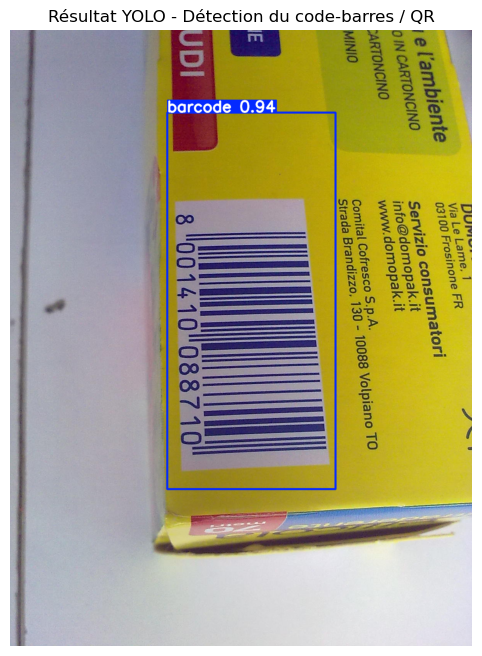

In [28]:
# Récupérer la première image traitée (il peut y en avoir plusieurs)
result = results[0]

# Récupérer les boîtes détectées
boxes = result.boxes  # contient les prédictions

# Récupérer l'image avec les boxes dessinées
annotated_image = result.plot()  # retourne un numpy array avec les annotations

# Convertir BGR -> RGB pour affichage correct avec matplotlib
annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

image = results[0].orig_img  # Récupérer l'image originale (non annotée)
decoded_any = False

#barcode_detector = cv2.barcode_BarcodeDetector()
reader = BarCodeReader()

# Afficher les informations pour chaque détection
for i, box in enumerate(boxes):
    cls_id = int(box.cls[0])          # ID de classe
    label = result.names[cls_id]      # nom de la classe (ex: 'barcode', 'qr')
    conf = float(box.conf[0])         # confiance
    xyxy = box.xyxy[0].tolist()       # coordonnées [xmin, ymin, xmax, ymax]
    
    print(f"Détection {i+1}:")
    print(f"  Classe      : {label}")
    print(f"  Confiance   : {conf:.2f}")
    print(f"  Coordonnées : {xyxy}")
    print("-" * 40)
        
    xmin, ymin, xmax, ymax = map(int, box.xyxy[0])
    

    # Extraire la région d'intérêt (ROI)
    roi = image[ymin:ymax, xmin:xmax]
    # === Prétraitement OpenCV ===
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)       # Améliorer contraste
    gray = cv2.GaussianBlur(gray, (3,3), 0)  # Lissage
    # Optionnel : binarisation adaptative
    bin_img = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                    cv2.THRESH_BINARY, 15, 10)

    """
    # OpenCV
    ok, decoded_info, decoded_type = barcode_detector.detectAndDecode(bin_img)
    if ok and decoded_info is not None and decoded_type is not None:
        for info, btype in zip(decoded_info, decoded_type):
            print("Type:", btype, "Value:", info)
    else:
        print("Aucun code-barres détecté dans la ROI.")
    """
 
    # === Sauvegarder temporairement la ROI pour ZXing ===
    #roi_path = tmp_dir / f"roi_{i}.jpg"
    roi_path = "C:/tmp/" + f"roi_{i}.jpg"
    cv2.imwrite(str(roi_path), gray)
    print('image: ', str(roi_path))
          
    # === Décodage ZXing ===
    decoded = reader.decode(str(roi_path))
    
    """    
    filtered_results = filter_barcode_results(decoded)

    if filtered_results and len(filtered_results) > 0:
        #for r in filtered_results:
        r = filtered_results[0]
        print(f"Type: {r.get('format')}, Value: {r.get('parsed')}, Points: {r.get('points')}, Score: {r.get('confidence')} ")
    else:
        print("  Aucun code-barres détecté avec ZXing pour cette ROI.")
        print("-" * 30)  
    """
    
    if decoded and len(decoded) > 0:
        #for d in decoded:
        d = decoded[0]
        print(f"  Type  : {d.get('format', 'Inconnu')}")
        print(f"  Valeur: {d.get('parsed', 'Aucune')}")
        print(f"  Points: {d.get('points', 'N/A')}")
        print("-" * 30)
        decoded_any = True
    else:
        print("  Aucun code-barres détecté avec ZXing pour cette ROI.")
        print("-" * 30)

if not decoded_any:
    print("Aucun code-barres détecté sur toute l'image.")
    
"""
    # === 3️⃣ Décodage avec Pyzbar ===
    decoded_objects = decode(roi)

    print(f"\nDétection {i+1} ({label}, conf={conf:.2f}) :")
    if decoded_objects:
        decoded_any = True
        for obj in decoded_objects:
            barcode_data = obj.data.decode("utf-8")
            barcode_type = obj.type
            print(f"  ➜ Contenu : {barcode_data}")
            print(f"  ➜ Type : {barcode_type}")

            # Dessiner le résultat sur l’image
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
            text = f"{label}:{conf:.2f} ({barcode_type})"
            cv2.putText(image, text, (xmin, ymin - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            cv2.putText(image, barcode_data, (xmin, ymax + 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)
    else:
        print("Aucun code-barres décodé dans cette zone.")
"""

# Convertir en image PIL pour affichage avec Matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(annotated_image_rgb)
plt.axis("off")
plt.title("Résultat YOLO - Détection du code-barres / QR")
plt.show()
#result.show()

In [29]:
# Sauvegarder le résultat annoté
cv2.imwrite(r"C:\CBDB\420-A62- Projet de synthèse\Barcode & QR Codes\decoded_image.jpg", annotated_image_rgb)


True

### Step 6 - Install YOLOv8 (Ultralytics)

* Installing YOLOv8 library (Ultralytics) for object detection.

In [31]:
!pip install ultralytics


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### Step 7 - Load and Train YOLOv8 Model

* Loading YOLOv8 Small model.

* Training it on custom barcode dataset for 50 epochs, 640x640 image size, and batch size of 16.

In [15]:
from ultralytics import YOLO

# Load YOLOv8s model
model = YOLO('yolov8s.pt')

# Train the model
model.train(
    data='/content/drive/MyDrive/Barcode_Decoder_Project_Final/new_dataset/data.yaml',   # Path to data.yaml
    epochs=50,         # Number of epochs for training
    imgsz=640,         # Image size (640x640 is default)
    batch=16,          # Batch size (adjust based on GPU memory)
)

Ultralytics 8.3.120 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/Barcode_Decoder_Project_Final/new_dataset/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True

train: Scanning /content/drive/MyDrive/Barcode_Decoder_Project_Final/new_dataset/train/labels.cache... 2000 images, 29 backgrounds, 192 corrupt: 100%|██████████| 2000/2000 [00:00<?, ?it/s]

train: /content/drive/MyDrive/Barcode_Decoder_Project_Final/new_dataset/train/images/01-event-sterling-banner-1_png_jpg.rf.0c76c75b7b55c29b3627eed5af5d9d80.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: /content/drive/MyDrive/Barcode_Decoder_Project_Final/new_dataset/train/images/1010_qr_jpg.rf.fb9b65521869d0e162183b752a1bc700.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: /content/drive/MyDrive/Barcode_Decoder_Project_Final/new_dataset/train/images/1026_qr_jpg.rf.270ebe73bfa2891f8d2b681a1413c967.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: /content/drive/MyDrive/Barcode_Decoder_Project_Final/new_dataset/train/images/1030_qr_jpg.rf.d96b2070c9c75700d8b4ff23b10cc407.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train


val: Scanning /content/drive/MyDrive/Barcode_Decoder_Project_Final/new_dataset/valid/labels.cache... 500 images, 11 backgrounds, 55 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]

val: /content/drive/MyDrive/Barcode_Decoder_Project_Final/new_dataset/valid/images/100_qr_jpg.rf.d1a8e050d8ce125e68ba730435322a66.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/drive/MyDrive/Barcode_Decoder_Project_Final/new_dataset/valid/images/101_qrcode_jpeg_jpg.rf.a52fd42a95e818ffbb3fee87886c6fad.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/drive/MyDrive/Barcode_Decoder_Project_Final/new_dataset/valid/images/1233_qr_jpg.rf.d5afc3823fd4705eec5cc67dbf328c6f.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/drive/MyDrive/Barcode_Decoder_Project_Final/new_dataset/valid/images/253_qr_jpg.rf.83f43696c077bfee68248582f6d66ba9.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/drive/MyDrive/Ba

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train5
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.714      3.912      1.933         35        640:  10%|▉         | 11/113 [08:48<1:21:36, 48.01s/it]


KeyboardInterrupt: 

### Step 8 - Prediction on a Single Image (Sample Test)

* Making a prediction on one test image.

* Displaying detected barcode bounding box.


image 1/1 /content/drive/MyDrive/Barcode_Decoder_Project_Final/new_dataset/train/images/4001133584517-01_N95_jpg.rf.f42957db4111b170ed7649ca52a1d802.jpg: 640x640 1 barcode, 1865.4ms
Speed: 6.5ms preprocess, 1865.4ms inference, 6.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict4


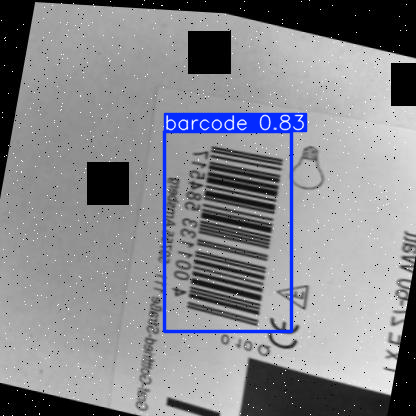

In [46]:
# Use the best.pt model to make predictions directly without retraining the model.
# model = YOLO('/content/drive/MyDrive/Barcode_Decoder_Project_Final/new_dataset/runs/detect/train/weights/best.pt')

# Predict on the image
results = model.predict(source='/content/drive/MyDrive/Barcode_Decoder_Project_Final/new_dataset/train/images/4001133584517-01_N95_jpg.rf.f42957db4111b170ed7649ca52a1d802.jpg', save=True)

# Access the first result object (since results is a list)
result = results[0]

# Show the image with the bounding boxes
result.show()


### Step 9 - Cropping Detected Barcodes

* Cropping barcode regions from detected bounding boxes.

* Saving cropped barcode images.

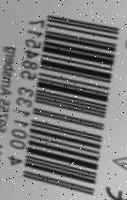

In [40]:
import cv2
from google.colab.patches import cv2_imshow
from pyzbar.pyzbar import decode

for result in results:
    boxes = result.boxes.xyxy  # Get bounding boxes (x1, y1, x2, y2)
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        cropped_barcode = result.orig_img[y1:y2, x1:x2]  # Crop image

        # Save cropped barcode image
        cv2.imwrite('/content/drive/MyDrive/Barcode_Decoder_Project_Final/cropped_barcodes/barcode_0.jpg', cropped_barcode)
        cv2_imshow(cropped_barcode)

        # Decode the barcode
        decoded_objects = decode(cropped_barcode)

        for obj in decoded_objects:
          print("Barcode Data:", obj.data.decode("utf-8"))
          print("Type:", obj.type)


### Step 10 - Decode Cropped Barcode

* Installing barcode decoding libraries.

* Decoding barcode data from cropped images.

In [28]:
!apt-get update
!apt-get install -y libzbar0

!pip install pyzbar


0% [Working]
            
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building depe

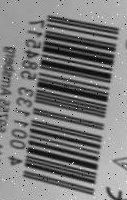

✅ Decoded Data: 4001133584517
📦 Barcode Type: EAN13


In [45]:
import cv2
from google.colab.patches import cv2_imshow
from pyzbar.pyzbar import decode

# Load image
img = cv2.imread('/content/drive/MyDrive/Barcode_Decoder_Project_Final/cropped_barcodes/barcode_0.jpg')
cv2_imshow(img)

# Decode and process each barcode
for obj in decode(img):
    # Decode data
    barcode_data = obj.data.decode('utf-8')
    barcode_type = obj.type

    # Print to console
    print("✅ Decoded Data:", barcode_data)
    print("📦 Barcode Type:", barcode_type)

    # Draw polygon around barcode
    points = obj.polygon
    pts = [(p.x, p.y) for p in points]
    for i in range(len(pts)):
        cv2.line(img, pts[i], pts[(i+1) % len(pts)], (0, 255, 0), 2)

    # Put decoded text on image
    cv2.putText(img, barcode_data, pts[0], cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

### Step 11 - Validate and Evaluate Model Performance

* Evaluating model on validation set to get mAP, Precision, Recall metrics.

In [13]:
metrics = model.val()  # Validate and evaluate model performance
print(metrics)  # Print evaluation metrics (mAP, precision, recall, etc.)

Ultralytics 8.3.120 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 10.5±3.2 MB/s, size: 18.8 KB)


val: Scanning /content/drive/MyDrive/Barcode_Decoder_Project_Final/new_dataset/valid/labels.cache... 500 images, 11 backgrounds, 55 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]

val: /content/drive/MyDrive/Barcode_Decoder_Project_Final/new_dataset/valid/images/100_qr_jpg.rf.d1a8e050d8ce125e68ba730435322a66.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/drive/MyDrive/Barcode_Decoder_Project_Final/new_dataset/valid/images/101_qrcode_jpeg_jpg.rf.a52fd42a95e818ffbb3fee87886c6fad.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/drive/MyDrive/Barcode_Decoder_Project_Final/new_dataset/valid/images/1233_qr_jpg.rf.d5afc3823fd4705eec5cc67dbf328c6f.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/drive/MyDrive/Barcode_Decoder_Project_Final/new_dataset/valid/images/253_qr_jpg.rf.83f43696c077bfee68248582f6d66ba9.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/drive/MyDrive/Ba


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


                   all        445        459      0.967       0.93      0.943      0.683
Speed: 1.4ms preprocess, 9.3ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/train3
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c63f0bae610>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033

### Step 12 - Save Trained Model

* Saving the final trained model for future use.

In [14]:
model.save('/content/drive/MyDrive/Barcode_Decoder_Project_Final/saved_model.pt')  # Save the model after training